In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('./diabetes.csv') 

In [4]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


<Axes: ylabel='count'>

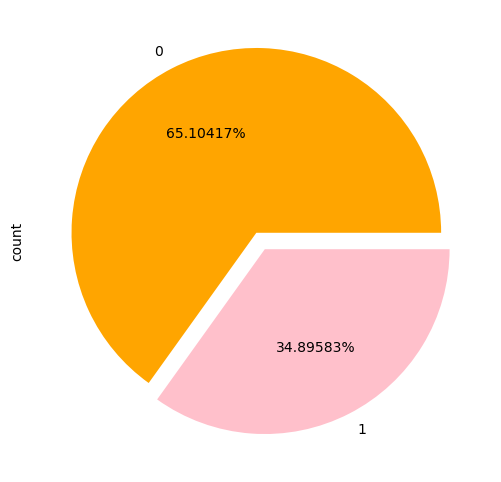

In [5]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
data.Outcome.value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['orange', 'pink'], explode=(0.05, 0.05))

In [6]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [7]:
# 데이터와 타겟 분리
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 8), (154, 8), (614,), (154,))

In [10]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [11]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

In [13]:
class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesDense()

In [14]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
# 손실 값과 정확도를 저장할 리스트
train_losses = []
test_accuracies = []

# 에폭 수만큼 학습 반복
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정 (Dropout, BatchNorm 등을 활성화)
    running_loss = 0.0  # 에폭 동안의 누적 손실 초기화

    # 학습 데이터셋에 대해 반복
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()         # 누적된 그래디언트 초기화
        outputs = model(inputs)       # 순전파 수행
        loss = criterion(outputs, labels)  # 손실 함수 계산
        loss.backward()              # 역전파 수행
        optimizer.step()             # 가중치 업데이트
        running_loss += loss.item()  # 손실 누적

    # 에폭별 평균 손실 저장
    train_losses.append(running_loss / len(train_dataloader))

    # 테스트 정확도 평가
    model.eval()  # 모델을 평가 모드로 설정 (Dropout 등 비활성화)
    correct = 0
    total = 0
    with torch.no_grad():  # 평가 시 그래디언트 계산 생략 (속도 향상, 메모리 절약)
        for inputs, labels in test_dataloader:
            outputs = model(inputs)  # 순전파 수행
            predicted = (torch.sigmoid(outputs) >= 0.5).float()  # 확률 → 클래스 변환 (이진 분류)
            total += labels.size(0)  # 전체 샘플 수 증가
            correct += (predicted == labels).sum().item()  # 정답 맞춘 개수 누적

    # 정확도 계산 및 저장
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    # 에폭별 학습 결과 출력
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

# 학습 완료 메시지
print("Training complete.")


Epoch 1/20, Loss: 0.6758, Accuracy: 74.03%
Epoch 2/20, Loss: 0.6309, Accuracy: 76.62%
Epoch 3/20, Loss: 0.5711, Accuracy: 77.92%
Epoch 4/20, Loss: 0.5330, Accuracy: 79.22%
Epoch 5/20, Loss: 0.4983, Accuracy: 80.52%
Epoch 6/20, Loss: 0.4862, Accuracy: 81.17%
Epoch 7/20, Loss: 0.4796, Accuracy: 82.47%
Epoch 8/20, Loss: 0.4672, Accuracy: 81.17%
Epoch 9/20, Loss: 0.4601, Accuracy: 82.47%
Epoch 10/20, Loss: 0.4645, Accuracy: 81.17%
Epoch 11/20, Loss: 0.4623, Accuracy: 81.82%
Epoch 12/20, Loss: 0.4438, Accuracy: 83.77%
Epoch 13/20, Loss: 0.4435, Accuracy: 83.77%
Epoch 14/20, Loss: 0.4423, Accuracy: 83.77%
Epoch 15/20, Loss: 0.4410, Accuracy: 84.42%
Epoch 16/20, Loss: 0.4387, Accuracy: 84.42%
Epoch 17/20, Loss: 0.4394, Accuracy: 84.42%
Epoch 18/20, Loss: 0.4323, Accuracy: 83.77%
Epoch 19/20, Loss: 0.4414, Accuracy: 82.47%
Epoch 20/20, Loss: 0.4218, Accuracy: 82.47%
Training complete.


In [16]:
# 모델 평가 모드로 전환 (Dropout, BatchNorm 비활성화)
model.eval()

# 실제 라벨과 예측값 저장용 리스트
all_labels = []
all_predictions = []

# 평가 시에는 그래디언트 계산 불필요 → torch.no_grad()로 메모리/속도 최적화
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)  # 순전파 수행
        _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 클래스 선택
        all_labels.extend(labels.cpu().numpy())       # 실제 정답 저장
        all_predictions.extend(predicted.cpu().numpy())  # 예측 결과 저장

# 리스트를 numpy 배열로 변환 (scikit-learn 사용을 위함)
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# 평가 지표 계산
conf_matrix = confusion_matrix(all_labels, all_predictions)  # 혼동 행렬
f1 = f1_score(all_labels, all_predictions, average='weighted')  # F1 점수 (클래스 불균형 고려)
precision = precision_score(all_labels, all_predictions, average='weighted')  # 정밀도
recall = recall_score(all_labels, all_predictions, average='weighted')  # 재현율

# 클래스별 Specificity 계산
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])  # True Negative
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]  # False Positive
    specificity.append(tn / (tn + fp))  # Specificity = TN / (TN + FP)

# 결과 출력
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')  # 평균 Specificity 출력


Confusion Matrix:
[[107   0]
 [ 47   0]]
F1 Score: 0.57
Precision: 0.48
Recall: 0.69
Specificity: 0.50


c:\Users\syjwk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


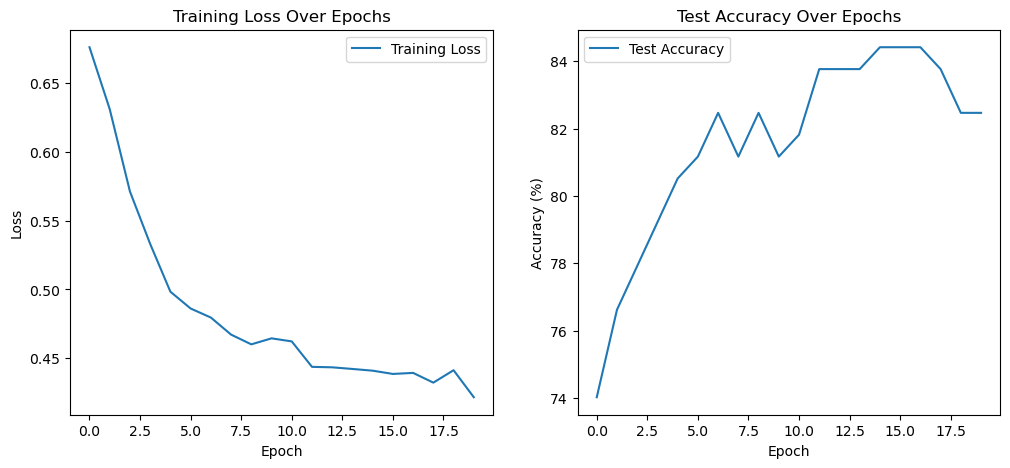

In [17]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()